In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MT5ForConditionalGeneration, T5Config, MT5Config
from MT6 import MT6
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import List, Union, Dict
from transformers import AutoModelForSeq2SeqLM
import torch
from transformers import MBartConfig

In [2]:
def cos_sim(named_weights: Dict[str, torch.Tensor], dim: int) -> Dict[str, torch.Tensor]:
    sim: Dict[str, torch.Tensor] = {}
    names = list(named_weights.keys())
    for i in range(len(names) - 1):
        m_i = names[i]
        for j in range(i + 1, len(names)):
            m_j = names[j]
            with torch.no_grad():
                sim[f"{m_i},{m_j}"] = torch.nn.functional.cosine_similarity(named_weights[m_i], named_weights[m_j],
                                                                            dim=dim).numpy()
    return sim

In [3]:
from utilities.models import get_all_mt6_models
mt6_models = get_all_mt6_models()
mt6_tok = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
mt6_rnd = MT5ForConditionalGeneration(
    MT5Config(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=len(mt6_tok), max_length=128,
              tie_word_embeddings=True))
col_names = ['M1, M2', 'M1, M2R', 'M1, M3', 'M1, M3R', 'M2, de', 'M2, rnd']

# Analisys on Embeddings

In [7]:
embed_m1 = mt6_models["M1"].shared.weight
embed_m2 = mt6_models["M2"].shared.weight
embed_m2_r = mt6_models["M2_replay"].shared.weight
embed_m3 = mt6_models["M3"].shared.weight
embed_m3_r = mt6_models["M3_replay"].shared.weight
embed_de = mt6_models["M2_de_only"].shared.weight
embed_rnd = mt6_rnd.shared.weight

0    0.938342
1    0.957770
2    0.884161
3    0.937502
4    0.000355
5   -0.000139
dtype: float32


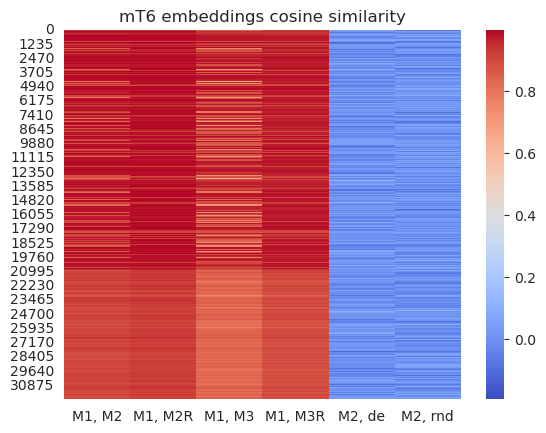

In [10]:
with torch.no_grad():
    df_emb = pd.DataFrame([torch.nn.functional.cosine_similarity(embed_m1, embed_m2).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1, embed_m2_r).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1, embed_m3).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1, embed_m3_r).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m2, embed_de).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m2, embed_rnd).numpy()])

print(df_emb.T.mean(axis=0))
g = sns.heatmap(df_emb.T, cmap="coolwarm")
g.set(title="mT6 embeddings cosine similarity")
g.set_xticklabels(col_names)
plt.show()

In [11]:
with torch.no_grad():
    print(torch.norm(embed_m1 - embed_m2))
    print(torch.norm(embed_m2 - embed_m3))
    print(torch.norm(embed_m1 - embed_m3))
    print(torch.norm(embed_de - embed_m2))
    print(torch.norm(embed_rnd - embed_m2))

tensor(1610.0215)
tensor(1644.0083)
tensor(2251.2764)
tensor(6316.3628)
tensor(6067.7163)


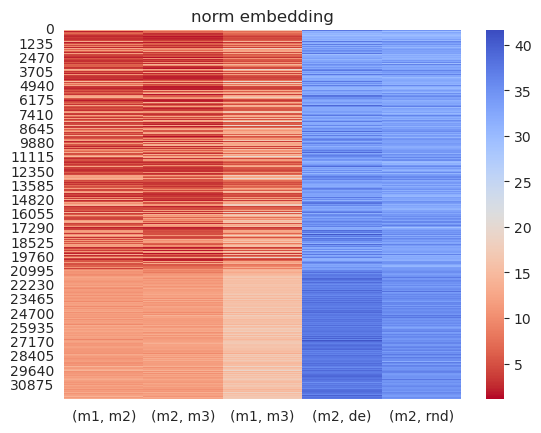

               0          1          2          3          4
0       1.576749   1.472145   2.938687  30.903955  29.951269
1       3.125235   2.202735   4.316949  34.169334  31.383856
2       4.940795   6.035008   7.832065  34.652260  34.547642
3      11.464273  11.580461  15.982256  38.992462  34.073135
4      12.710846  12.477154  16.897631  39.164234  36.101616
...          ...        ...        ...        ...        ...
32098  11.323394  12.041915  15.983937  38.702633  35.333027
32099  12.406716  10.140062  15.544929  37.006405  34.894878
32100  13.057215  12.654149  17.388655  37.419022  35.207550
32101  10.335738  13.163833  16.450306  36.677383  34.427902
32102  11.541473  13.509019  17.243467  38.464584  34.874981

[32103 rows x 5 columns]


In [12]:
norm_emb = np.zeros((embed_m1.shape[0], 5))
with torch.no_grad():
    for i in range(embed_m1.shape[0]):
        norm_emb[i, 0] = torch.norm(embed_m1[i, :] - embed_m2[i, :])
        norm_emb[i, 1] = torch.norm(embed_m2[i, :] - embed_m3[i, :])
        norm_emb[i, 2] = torch.norm(embed_m1[i, :] - embed_m3[i, :])
        norm_emb[i, 3] = torch.norm(embed_m2[i, :] - embed_de[i, :])
        norm_emb[i, 4] = torch.norm(embed_m2[i, :] - embed_rnd[i, :])

g = sns.heatmap(norm_emb, cmap="coolwarm_r")
g.set(title="norm embedding")
g.set_xticklabels(col_names)
plt.show()
print(pd.DataFrame(norm_emb))

# Analysis on Encoder Last Hidden state

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
tok_out = tokenizer("Hello how are you? This is my dog.", text_target="", return_tensors="pt")
col_tokens = tokenizer.batch_decode(tok_out['input_ids'].squeeze())

with torch.no_grad():
    seq2seq_out_m1 = m1_model(**tok_out)
    seq2seq_out_m2 = m2_model(**tok_out)
    seq2seq_out_m3 = m3_model(**tok_out)
    seq2seq_out_de = de_model(**tok_out)
    seq2seq_out_rnd = rnd_model(**tok_out)

last_hidd_state_m1 = seq2seq_out_m1['encoder_last_hidden_state'].squeeze().T
last_hidd_state_m2 = seq2seq_out_m2['encoder_last_hidden_state'].squeeze().T
last_hidd_state_m3 = seq2seq_out_m3['encoder_last_hidden_state'].squeeze().T
last_hidd_state_de = seq2seq_out_de['encoder_last_hidden_state'].squeeze().T
last_hidd_state_rnd = seq2seq_out_rnd['encoder_last_hidden_state'].squeeze().T

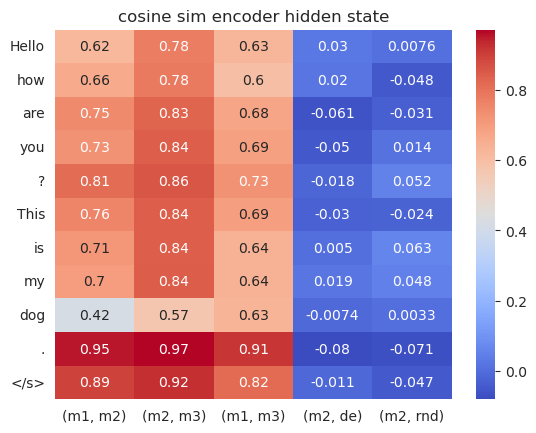

In [20]:
with torch.no_grad():
    cos_sim_hs_m1_m2 = torch.nn.functional.cosine_similarity(last_hidd_state_m1, last_hidd_state_m2, dim=0)
    cos_sim_hs_m2_m3 = torch.nn.functional.cosine_similarity(last_hidd_state_m2, last_hidd_state_m3, dim=0)
    cos_sim_hs_m1_m3 = torch.nn.functional.cosine_similarity(last_hidd_state_m1, last_hidd_state_m3, dim=0)
    cos_sim_hs_m2_de = torch.nn.functional.cosine_similarity(last_hidd_state_m2, last_hidd_state_de, dim=0)
    cos_sim_hs_rnd_de = torch.nn.functional.cosine_similarity(last_hidd_state_rnd, last_hidd_state_de, dim=0)
    df_cos_hs = pd.DataFrame(
        [cos_sim_hs_m1_m2.numpy(), cos_sim_hs_m2_m3.numpy(), cos_sim_hs_m1_m3.numpy(), cos_sim_hs_m2_de.numpy(),
         cos_sim_hs_rnd_de.numpy()],
        columns=col_tokens)

#print(df_cos_hs)
g = sns.heatmap(df_cos_hs.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim encoder hidden state")
#g.set_xticks(range(len(df_cos_hs))) # <--- set the ticks first
g.set_xticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

# Analysis on Logits

In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
tok_out = tokenizer("Hallo, wie geht's dir? Das ist <extra_id_0> Hund.", text_target="Hallo, wie geht's dir? Das ist mein Hund.",
                    return_tensors="pt")
col_tokens = tokenizer.batch_decode(tok_out['input_ids'].squeeze())

In [44]:
with torch.no_grad():
    seq2seq_out_m1 = m1_model(**tok_out)
    seq2seq_out_m2 = m2_model(**tok_out)
    seq2seq_out_m3 = m3_model(**tok_out)
    seq2seq_out_de = de_model(**tok_out)
    seq2seq_out_rnd = rnd_model(**tok_out)

logits_m1 = seq2seq_out_m1['logits'].squeeze().T
logits_m2 = seq2seq_out_m2['logits'].squeeze().T
logits_m3 = seq2seq_out_m3['logits'].squeeze().T
logits_de = seq2seq_out_de['logits'].squeeze().T
logits_rnd = seq2seq_out_rnd['logits'].squeeze().T

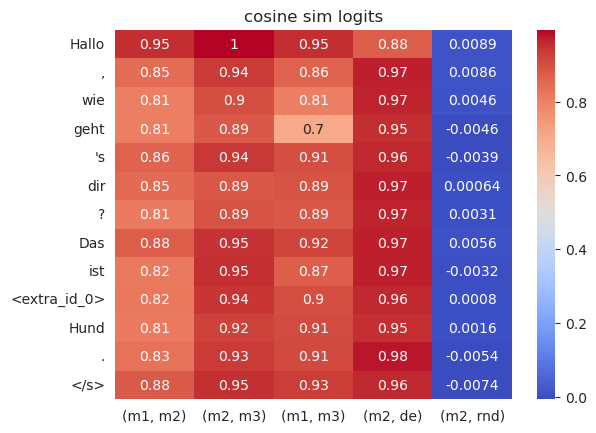

In [45]:
with torch.no_grad():
    cos_sim_lg_m1_m2 = torch.nn.functional.cosine_similarity(logits_m1, logits_m2, dim=0)
    cos_sim_lg_m2_m3 = torch.nn.functional.cosine_similarity(logits_m2, logits_m3, dim=0)
    cos_sim_lg_m1_m3 = torch.nn.functional.cosine_similarity(logits_m1, logits_m3, dim=0)
    cos_sim_lg_m2_de = torch.nn.functional.cosine_similarity(logits_m2, logits_de, dim=0)
    cos_sim_lg_rnd_de = torch.nn.functional.cosine_similarity(logits_rnd, logits_de, dim=0)
    df_cos_lg = pd.DataFrame(
        [cos_sim_lg_m1_m2.numpy(), cos_sim_lg_m2_m3.numpy(), cos_sim_lg_m1_m3.numpy(), cos_sim_lg_m2_de.numpy(),
         cos_sim_lg_rnd_de.numpy()],
        columns=col_tokens)

g = sns.heatmap(df_cos_lg.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim logits")
g.set_xticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

In [33]:
cos_sim_lg_m1_m2

tensor(0.9532)

In [15]:
# lg_w = {"m1": logits_m1, "m2": logits_m2, "m3": logits_m3, "de": logits_de, "rnd": logits_rnd}
# cos_sim_lg = cos_sim(lg_w, dim=0)
# #print(cos_sim_lg)
# df_cos_lg = pd.DataFrame(
#     cos_sim_lg.values(),
#     columns=col_tokens)
#
# g = sns.heatmap(df_cos_lg.T, cmap="coolwarm", annot=True)
# g.set(title="cosine sim logits")
# g.set_xticklabels(cos_sim_lg.keys())
# plt.show()

# Analysis on Attentions

In [11]:
from transformers import PreTrainedModel


def generate_attention_graphs(models: Dict[str, PreTrainedModel], tok_out) -> str:
    html_code = ""
    labels = tok_out['labels']
    decoder_input_ids = torch.zeros_like(labels)
    decoder_input_ids[:, 0] = labels[:, -1]
    decoder_input_ids[:, 1:] = labels[:, :-1]
    for m_k, m in models.items():
        with torch.no_grad():
            att = m(input_ids=out_tok['input_ids'], decoder_input_ids=decoder_input_ids)
        encoder_text = tokenizer.convert_ids_to_tokens(tok_out["input_ids"].squeeze())
        decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids.squeeze())
        mv = model_view(
            encoder_attention=att.encoder_attentions,
            decoder_attention=att.decoder_attentions,
            cross_attention=att.cross_attentions,
            encoder_tokens=encoder_text,
            decoder_tokens=decoder_text,
            html_action="return",
            display_mode="light"
        )

        html_code += f"<h3> {m_k} </h3> \n" + mv.data

    return html_code

In [6]:
from bertviz import model_view
from transformers import AutoTokenizer

#tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")

In [14]:
src_txt, tgt_txt = "Hello how are you? This is my dog.", "Bonjour comment allez-vous? C'est mon chien."
out_tok = tokenizer(src_txt, text_target=tgt_txt, return_tensors="pt", add_special_tokens=True)
print(generate_attention_graphs({"m1": m1_model, "m2": m2_model, "de": de_model}, out_tok))

<h3> m1 </h3> 
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>      
        <div id="bertviz-f84d9c7d371c4ee2b735ea064205554b" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Attention: <select id="filter"><option value="0">Encoder</option>
<option value="1">Decoder</option>
<option value="2">Cross</option></select>
            </span>
            <div id='vis'></div>
        </div>
    
<script type="text/javascript">
/**
 * @fileoverview Transformer Visualization D3 javascript code.
 *
 * Based on: https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/visualization/attention.js
 *
 * Change log:
 *
 * 02/01/19  Jesse Vig   Initial implementation
 * 12/31/20  Jesse Vig   Support multiple visualizations in single notebook.
 * 01/19/21  Jesse Vig   Support light/dark modes
 * 02/06/21  Jesse Vig   Move require config from separate jupyter noteb